In [1]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb 

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.data_fetching as data_fetching
import Components.feature_extraction as feature_extraction
import Components.Classifying_Transformer as clt
import Components.Smoothing_Classifier as smcl
import Components.Neighbour_Features as nf

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(data_fetching)
importlib.reload(feature_extraction)
importlib.reload(clt)
importlib.reload(smcl)
importlib.reload(nf)

<module 'Components.Neighbour_Features' from '../Components/Neighbour_Features.py'>

# Data Fetching

In [2]:
_, y = data_fetching.get_train_data()
y = np.ravel(y)

In [3]:
X = feature_extraction.get_features(None, precomputed='train')
X_test = feature_extraction.get_features(None, precomputed='test')

# Cross-validation

In [18]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('PCA', PCA(n_components=183)),
                 ('neighbour_features', nf.Neighbour_Features(lag=2)),
                 ('classification',lgb.LGBMClassifier(class_weight = 'balanced'))])

In [19]:
# Train on 2 subjects, test on the other
n_epochs = 21600
splits = [(np.r_[0:2*n_epochs], np.r_[2*n_epochs:3*n_epochs]),
 (np.r_[0:n_epochs, 2*n_epochs:3*n_epochs], np.r_[n_epochs:2*n_epochs]),
 (np.r_[n_epochs:3*n_epochs], np.r_[0:n_epochs])]

# format: 
# [(train_indices, test_indices),
#    (train_indices, test_indices),....]

cv_score = cross_val_score(pipe, X, y, cv=splits, scoring='balanced_accuracy',n_jobs=16)
print(cv_score)
print(f"mean: {np.mean(cv_score)}")
print(f"standard deviation: {np.std(cv_score)}")

#LGB all MNE features
#[0.70943547 0.95720017 0.88320811]
#0.8499479178461647
# standard deviation 0.10384769933882516

# both steps LGB, lag 5, border-vote 5
#[0.5997921  0.95668261 0.8793381 ]
#0.8119376038984457

# both steps LGB, lag 10, border-vote 5
#[0.60192032 0.95705123 0.87927879]
#0.8127501105221282
#standard deviation 0.15242274419875892

# both steps LGB, lag 100, border-vote 5
#[0.60703004 0.95650736 0.8793381 ]
#0.814291835327246

# both steps LGB, lag 200, border-vote 5
#[0.5985031  0.95719145 0.87924913]
#0.8116478914896422

# PCA 90 features of neighbors with lag 2, LGB
#[0.88570544 0.96200852 0.88843848]
#0.9120508105283455
# standard deviation 0.03534304946713885

# PCA 90 features of neighbors with lag 5, LGB
#[0.88625419 0.96170667 0.88667096]
#0.9115439404692363
# standard deviation 0.03547081172345031

# PCA 90 features of neighbors with lag 3, LGB
#[0.861241   0.96152223 0.89151204]
#mean: 0.9047584237384917
#standard deviation: 0.04199747226951646

# PCA 90 features of neighbors with lag 10, LGB
#[0.89934699 0.95969502 0.89153696]
#mean: 0.9168596564263747
#standard deviation: 0.0304565305043997

# PCA 183 features of neighbors with lag 2, LGB
#[0.88929445 0.9606122  0.89447762]
#mean: 0.9147947558993065
#standard deviation: 0.032466852580241304

[0.88929445 0.9606122  0.89447762]
mean: 0.9147947558993065
standard deviation: 0.032466852580241304


# Prediction

In [15]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('PCA', PCA(n_components=90)),
                 ('neighbour_features', nf.Neighbour_Features(lag=2)),
                 ('classification',lgb.LGBMClassifier(class_weight = 'balanced'))])

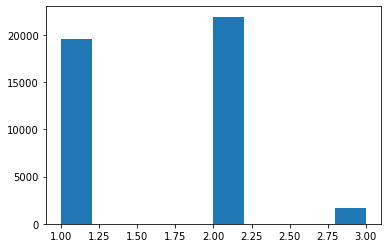

In [16]:
pipe.fit(X,y)
y_pred = pipe.predict(X_test)
plt.hist(y_pred)



In [17]:
y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/LGB_MNE_Features_10_neighbours.csv', index_label='Id')

# Plots

**sleep stages of first subject**

In [5]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('individual_classification', clt.Classifying_Transformer(lgb.LGBMClassifier(class_weight = 'balanced'))),
                 ('smoothing', smcl.Smoothing_Classifier(lgb.LGBMClassifier(class_weight = 'balanced'), lag= 100, border_vote = 5))])

In [6]:
n_epochs = 21600
X_train_split = X[:2*n_epochs]
y_train_split = y[:2*n_epochs]
pipe.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaling', StandardScaler()),
                ('individual_classification',
                 Classifying_Transformer(clf=LGBMClassifier(class_weight='balanced'))),
                ('smoothing',
                 Smoothing_Classifier(clf=LGBMClassifier(class_weight='balanced'),
                                      lag=100))])

In [7]:
y_train_pred = pipe.predict(X[2*n_epochs:])

In [12]:
X[2*n_epochs:]

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
43200,1.033303,0.920015,1.213831,0.078125,0.078125,0.062500,0.000020,0.000033,0.000045,0.000071,...,-0.540018,1.534146e-16,0.837714,2.162286,-0.267581,-0.679056,-0.525617,4.440892e-16,1.257124,1.742876
43201,1.052345,1.016056,1.202260,0.046875,0.046875,0.070312,0.000007,0.000031,0.000070,0.000092,...,-0.557447,2.718501e-16,0.800382,2.199618,-0.275834,-0.704314,-0.488074,2.220446e-16,1.254318,1.745682
43202,1.100242,1.020074,1.262230,0.078125,0.062500,0.070312,0.000030,0.000028,0.000039,0.000063,...,-0.668729,4.375348e-16,0.624054,2.375946,-0.307308,-0.715366,-0.445100,2.220446e-16,1.266975,1.733025
43203,1.032172,1.003457,1.167331,0.046875,0.039062,0.054688,0.000008,0.000039,0.000072,0.000082,...,-0.538612,4.900594e-17,0.928500,2.071500,-0.245851,-0.683546,-0.539455,0.000000e+00,1.237915,1.762085
43204,1.103244,1.040231,1.319207,0.046875,0.101562,0.062500,0.000009,0.000032,0.000062,0.000072,...,-0.769731,8.474383e-16,0.486642,2.513358,-0.200466,-0.737942,-0.513232,0.000000e+00,1.186706,1.813294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,1.263937,1.272850,1.239550,0.070312,0.390625,0.070312,0.000009,0.000009,0.000012,0.000041,...,-0.463078,2.220446e-16,1.162657,1.837343,-0.225991,-0.684277,-0.555716,4.440892e-16,1.220487,1.779513
64796,1.312695,1.271152,1.216475,0.054688,0.070312,0.078125,0.000011,0.000012,0.000016,0.000038,...,-0.400807,4.440892e-16,1.203524,1.796476,-0.364802,-0.700232,-0.409270,2.220446e-16,1.297745,1.702255
64797,1.321057,1.307834,1.310242,0.070312,0.164062,0.062500,0.000005,0.000011,0.000012,0.000041,...,-0.232369,4.440892e-16,1.197799,1.802201,-0.255276,-0.698100,-0.514069,2.220446e-16,1.241587,1.758413
64798,1.359234,1.309974,1.230043,0.054688,0.054688,0.070312,0.000004,0.000011,0.000012,0.000049,...,-0.199717,4.440892e-16,1.104670,1.895330,-0.313636,-0.705308,-0.451922,0.000000e+00,1.276258,1.723742


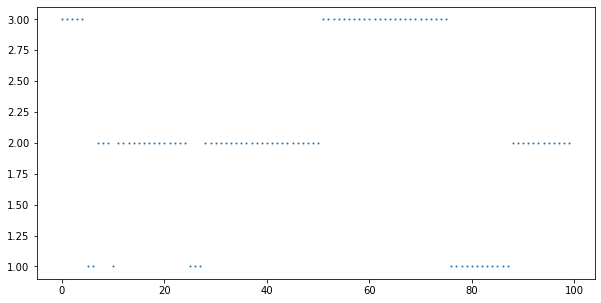

In [11]:
stages=y[n_epochs:n_epochs+100]
time = range(len(stages))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages, s=1)

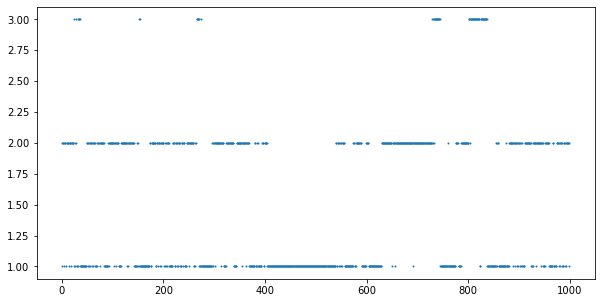

In [15]:
stages_pred = y_train_pred[9000:10000]
time = range(len(stages_pred))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages_pred, s=1)

In [12]:
pipe2 = Pipeline([('scaling',StandardScaler()),
                 ('classification', lgb.LGBMClassifier(class_weight = 'balanced'))])
pipe2.fit(X_train_split, y_train_split)
y_train_pred2 = pipe2.predict(X[2*n_epochs:])

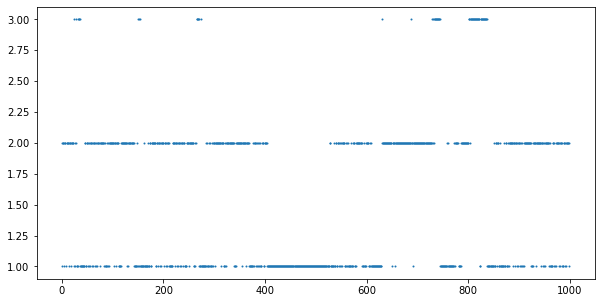

In [14]:
stages_pred2 = y_train_pred2[9000:10000]
time = range(len(stages_pred2))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages_pred2, s=1)

In [18]:
X.shape

(64800, 183)